In this notebook we show how to use the Pytorch SDO dataset and the data loader to pass the SDO dataset in batches to a NN model. **Last updated 21th July 2019.**

In [1]:
import logging
import sys
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from matplotlib.pyplot import imshow

import torch
from torch import nn, optim
from sdo.sdo_dataset import SDO_Dataset
from torch.utils.data import DataLoader
from torch.nn import functional as F

from sdo.models.encoder_decoder import AutoEncoder

%matplotlib inline

In [2]:
#just a way to get nice logging messages from the sdo package
logformat = "[%(asctime)s] %(levelname)s:%(name)s:%(message)s"
logging.basicConfig(level=logging.DEBUG, stream=sys.stdout, format=logformat, datefmt="%Y-%m-%d %H:%M:%S")

In [3]:
# we tried with a few of channels combinations, the larger the difference in absolute values beetween channels, 
# the more problematic the convergence (see spikes below) with ['0171', '0193', '0094'] being the worst
# of the 3 combinations
subsample = 1
original_ratio = 512
img_shape = int(original_ratio/subsample)
#instr = ['AIA', 'AIA', 'AIA']
#channels = ['0171', '0193', '0094']
#instr = ['AIA', 'AIA']
#channels = ['0171', '0193']
instr = ['AIA', 'AIA', 'AIA']
channels = ['0171', '0193', '0304']

In [4]:
#some cuda initialization
torch.backends.cudnn.enabled = True
cuda_device = 3
if not torch.cuda.is_available():
    raise RuntimeError("CUDA not available! Unable to continue")
device = torch.device("cuda:{}".format(cuda_device))
print("Using device {} for training, current device: {}, total devices: {}".format(
device, torch.cuda.current_device(), torch.cuda.device_count()))

Using device cuda:3 for training, current device: 0, total devices: 6


In [5]:
# after some discussion we found scaling seems the more appropriate choice
# with the following choice of parameters we are selecting one image for day
# November and Dicember are not available because we are keeping them as holdout
train_data = SDO_Dataset(device=device, instr=instr, channels=channels, yr_range=[2011, 2018], 
                         mnt_step=1, day_step=1, h_step=24, min_step=60, subsample=subsample, 
                         test_ratio= 0.3, normalization=0, scaling=True)
test_data = SDO_Dataset(device=device, instr=instr, channels=channels, yr_range=[2011, 2018], 
                        mnt_step=1, day_step=1, h_step=24, min_step=60, subsample=subsample, 
                        test_ratio= 0.3, normalization=0, scaling=True, test=True)

[2019-07-22 01:40:25] INFO:sdo.sdo_dataset:Loading SDOML from "/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML"
[2019-07-22 01:40:25] INFO:sdo.sdo_dataset:Training on months "[1 2 3 4 5 6 7]"
[2019-07-22 01:40:25] DEBUG:sdo.sdo_dataset:Timestamps requested values: 
[2019-07-22 01:40:25] DEBUG:sdo.sdo_dataset:Years: 2011,2012,2013,2014,2015,2016,2017,2018
[2019-07-22 01:40:25] DEBUG:sdo.sdo_dataset:Months: 1,2,3,4,5,6,7
[2019-07-22 01:40:25] DEBUG:sdo.sdo_dataset:Days: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
[2019-07-22 01:40:25] DEBUG:sdo.sdo_dataset:Hours: 0
[2019-07-22 01:40:25] DEBUG:sdo.sdo_dataset:Minutes: 0
[2019-07-22 01:40:25] INFO:sdo.sdo_dataset:Max number of timestamps: 1736
[2019-07-22 01:40:28] INFO:sdo.sdo_dataset:Timestamps found in the inventory: 1664 (0.96)
[2019-07-22 01:40:28] INFO:sdo.sdo_dataset:N timestamps discarded because channel is missing = 0 (0.00000)
[2019-07-22 01:40:28] INFO:sdo.sdo_dataset:Selected timestamps = 1664
[2

In [6]:
train_data_loader = DataLoader(train_data, batch_size=10, shuffle=True)

0 torch.Size([10, 3, 512, 512])
0171
tensor(5.5699, device='cuda:3') tensor(0., device='cuda:3')
tensor([[4.2537e-04, 7.0911e-05, 2.0256e-05,  ..., 9.3412e-05, 2.2871e-04,
         1.8319e-04],
        [5.8540e-04, 2.1503e-04, 2.0347e-04,  ..., 4.8276e-04, 1.4179e-04,
         4.2623e-04],
        [1.9405e-04, 2.4524e-04, 2.1405e-04,  ..., 8.1024e-05, 1.4179e-04,
         1.4179e-04],
        ...,
        [2.2912e-04, 1.6205e-04, 1.2154e-04,  ..., 2.5915e-04, 2.6492e-04,
         4.5223e-04],
        [2.7815e-04, 1.4188e-04, 0.0000e+00,  ..., 5.9611e-04, 3.1221e-04,
         3.2139e-04],
        [1.6205e-04, 5.3216e-04, 1.2154e-04,  ..., 2.5314e-04, 2.5664e-04,
         3.0491e-04]], device='cuda:3')
5.5699124 0.0 0.2702634 0.18300088
0193
tensor(3.1559, device='cuda:3') tensor(0., device='cuda:3')
tensor([[1.2972e-04, 2.7168e-04, 2.7161e-04,  ..., 9.3761e-05, 1.4435e-04,
         8.0751e-05],
        [2.5584e-04, 2.1045e-04, 2.7729e-04,  ..., 1.7282e-04, 1.6552e-04,
         1.2704e-0

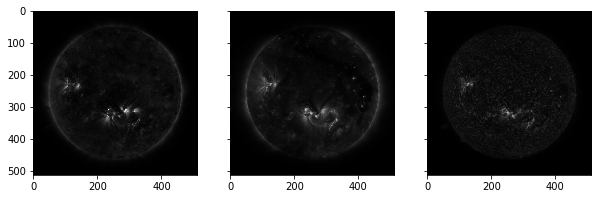

In [8]:
# just selecting one single image at random
#a way to check the shape is as expected and the loader works
for batch_index, batch in enumerate(train_data_loader):
    print(batch_index, batch.shape)
    fig, ax = plt.subplots(1, 3, figsize=(10,10), sharey=True)
    for i in range(len(channels)):
        print(channels[i])
        item = batch[4,i,:,:]
        print(torch.max(item), torch.min(item))
        print(item)
        print(item.cpu().numpy().max(), item.cpu().numpy().min(), item.cpu().numpy().std(), np.median(item.cpu().numpy()))
        ax[i].imshow(batch[4,i,:,:].cpu().numpy(), cmap='gray')
    break

Since it seems to work we can try to run it on a simple model.

In [9]:
# initializaion of DNN model and parameters
model = AutoEncoder(input_shape=[len(channels), img_shape,img_shape])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.MSELoss()

Autoencoder architecture:
Input shape: [3, 512, 512]
Input dim  : 786432
Encoded dim: 57600
Hidden dim : 512
Learnable params: 59669699


In [10]:
# training loop
model.cuda(cuda_device)
len_data = train_data.__len__()
log_interval = 10
n_epochs = 4
train_loss = []
for epoch in range(n_epochs):
    for batch_index, batch in enumerate(train_data_loader):
        data = batch.to(cuda_device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data)
        train_loss.append(float(loss))
        loss.backward()
        optimizer.step()
        if batch_index % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_index * len(data), len_data, 
                100.*(batch_index* len(data)) / len_data, 
                loss.item() / len(data)))

Train Epoch: 0 [0/1664 (0%)]	Loss: 0.015806
Train Epoch: 0 [100/1664 (6%)]	Loss: 0.017254
Train Epoch: 0 [200/1664 (12%)]	Loss: 0.008134
Train Epoch: 0 [300/1664 (18%)]	Loss: 0.006182
Train Epoch: 0 [400/1664 (24%)]	Loss: 0.005403
Train Epoch: 0 [500/1664 (30%)]	Loss: 0.005733
Train Epoch: 0 [600/1664 (36%)]	Loss: 0.004989
Train Epoch: 0 [700/1664 (42%)]	Loss: 0.003962
Train Epoch: 0 [800/1664 (48%)]	Loss: 0.003377
Train Epoch: 0 [900/1664 (54%)]	Loss: 0.005047
Train Epoch: 0 [1000/1664 (60%)]	Loss: 0.003833
Train Epoch: 0 [1100/1664 (66%)]	Loss: 0.003113
Train Epoch: 0 [1200/1664 (72%)]	Loss: 0.002866
Train Epoch: 0 [1300/1664 (78%)]	Loss: 0.002986
Train Epoch: 0 [1400/1664 (84%)]	Loss: 0.004064
Train Epoch: 0 [1500/1664 (90%)]	Loss: 0.003298
Train Epoch: 0 [1600/1664 (96%)]	Loss: 0.003102
Train Epoch: 1 [0/1664 (0%)]	Loss: 0.002621
Train Epoch: 1 [100/1664 (6%)]	Loss: 0.002477
Train Epoch: 1 [200/1664 (12%)]	Loss: 0.001996
Train Epoch: 1 [300/1664 (18%)]	Loss: 0.002378
Train Epoch: 1

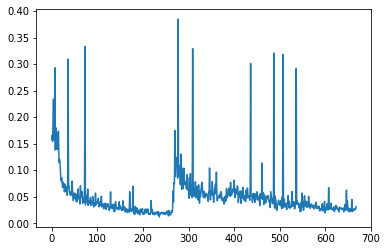

Loss min: 0.012113080359995365, max: 0.3844662606716156, mean: 0.04951973089635997


In [11]:
# there are some spikes in the loss function, probably related to the high intensity pixels that still exist 
# after the normalization "by mean that we are applying"
plt.plot(train_loss, label='training loss');
plt.show();
print('Loss min: {}, max: {}, mean: {}'.format(min(train_loss), max(train_loss), np.mean(train_loss)))

In [12]:
test_data_loader = DataLoader(test_data, batch_size=10, shuffle=True)

In [13]:
#getting a memory error here, don't know why
#test loop
len_data = test_data.__len__()
log_interval = 10
test_loss = []

for batch_index, batch in enumerate(test_data_loader):
    data = batch.to(cuda_device)
    recon_batch = model(data)
    loss = loss_function(recon_batch, data)
    test_loss.append(float(loss))
    if batch_index % log_interval == 0:
        print('Progress {:.2f} , Test Loss: {:.6f}'.format(
            100.*(batch_index* len(data)) / len_data, loss.item() / len(data)))

Progress: 0.0 , Test Loss: 0.002331
Progress: 14.245014245014245 , Test Loss: 0.002572
Progress: 28.49002849002849 , Test Loss: 0.003151
Progress: 42.73504273504273 , Test Loss: 0.002264
Progress: 56.98005698005698 , Test Loss: 0.002680
Progress: 71.22507122507122 , Test Loss: 0.002905
Progress: 85.47008547008546 , Test Loss: 0.002763
Progress: 19.943019943019944 , Test Loss: 0.019373


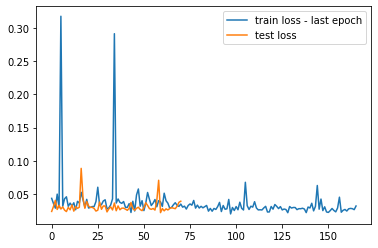

Loss min: 0.021515702828764915, max: 0.08837004750967026, mean: 0.030569712696990495


In [14]:
plt.plot(train_loss[-int(train_data.__len__()/10):], label='train loss - last epoch');
plt.plot(test_loss, label='test loss');
plt.legend()
plt.show();
print('Loss min: {}, max: {}, mean: {}'.format(min(test_loss), max(test_loss), np.mean(test_loss)))